<center>
    COMP4600/5300 - Reinforcement Learning

# Homework 8 - Policy Gradient

### Due: Wednesday, December 2nd 11:59 pm
    
</center>

Student Name: Amin Majdi 

The purpose of this project is to study different properties of Policy Gradient algorithms with Function Approximation.

In [1]:
# You are allowed to use the following modules
import numpy as np
import matplotlib.pyplot as plt
from mountain_car import MountainCar
import pygame as pg
from pygame import gfxdraw
import cma

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


## Task description
Consider the task of driving an underpowered car up a steep mountain road, as suggested by the diagram in the upper left of the following figure. The difficulty is that gravity is stronger than the car's engine, and even at full throttle the car cannot accelerate up the steep slope. The only solution is to first move away from the goal and up the opposite slope on the left. Then by applying full throttle the car can build up enough inertia to carry it up the steep slope even though it is slowing down the whole way.


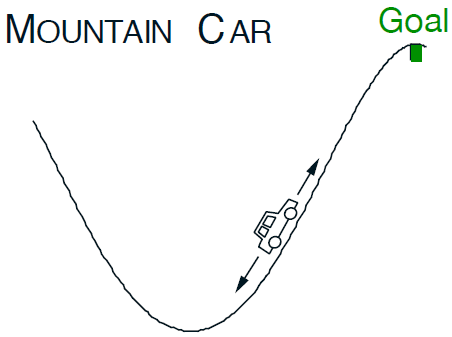


This is a continuous control task where things have to get worse in a sense (farther from the goal) before they can get better. The reward in this problem is -1 on all time steps until the car moves past its goal position at the top of the mountain, which ends the episode. There are three possible actions: full throttle forward (+1), full throttle reverse (-1), and zero throttle (0). The car moves according to a simplified physics. Its position $x_t$ and velocity $\dot{x}_t$ are updated by

$x_{t+1} \doteq \text{bound}[x_t + \dot{x}_{t+1}]$

$\dot{x}_{t+1} \doteq \text{bound}[\dot{x}_t + 0.001 A_t - 0.0025 \cos(3x_t)]$


where the \textit{bound} operation enforces $-1.2 \le x_{t+1} \le 0.5$ and $-0.07 \le \dot{x}_{t+1} \le 0.07$. In addition, when $x_{t+1}$ reached the left bound, $\dot{x}_{t+1}$ was reset to zero. When it reached the right bound, the goal was reached and the episode was terminated. Each episode starts from a random position $x_t \in [-0.6, -0.4)$ and zero velocity.




**Note:** You have been given a simple implementation of the Mountain Car task. You can use your implementation of the function approximation from Homework 6, or implement a new one. 


## Part I

Select and implement of the following algorithms (+10 for implementing both):

1.	REINFORCE with Baseline (p. 330)
2.	Actor-Critic with Eligibility Traces (p. 332)


In [2]:
# Your code here
state_num=2
action_num=3
order=3
d=(order+1)**state_num
d_a=d*action_num

def scale(state_):
    a_ = np.array([(state_[0] + 1.2) / 1.7,(state_[1] + 0.07) / 0.14])
    return a_

def create_c(k_,n_):#number of states, order
    c_ = [[] for j in range(k_)]
    for i in range(k_):
        for j in range(int(np.power(n_ + 1,i))):
            for p in range(n_ + 1):
                for r in range(int(np.power(n_ + 1,k_- i - 1))):
                    c_[i].append(p)
    c_ = np.array(c_,dtype = np.int8)
    return c_
c=create_c(state_num,order)

def create_x_i(s_,action_index_): #for theta
    state = scale(s_)
    x_i=np.cos(np.pi*(np.matmul(state,c)))
    zero = np.zeros((1,d))
    X_ = np.empty(0)
    for i in range(action_num):
        if i == action_index_:
            X_ = np.append(X_,x_i)
        else:
            X_ = np.append(X_,zero)

    return X_

def create_x_i_v(s_): #for v_hat
    state = scale(s_)
    x_i_=np.cos(np.pi*(np.matmul(state,c)))
    return x_i_


def policy(st,theta):
    h = np.empty(0)
    for i in range(action_num):
        h = np.append(h,np.matmul(theta,create_x_i(st,i)))#theta * x(A_t,S_t
    exp = np.exp(h - np.max(h))
    soft_ = exp / np.sum(exp)

    return soft_

def creat_v_hat(s_in,w_in):
    x_ = create_x_i_v(s_in)
    v_ = np.matmul(w_in,x_)
    return v_ , x_

def nubla_ln_policy(s_,action_index_,theta_):
    x_i_ = create_x_i(s_,action_index_)
    soft_ = policy(s_,theta_)
    sum_ = np.zeros((1,len(x_i_)))
    for i in range(action_num):
        sum_ += soft_[i] * create_x_i(s_,i)
    nubla = x_i_ - sum_
    return nubla
    


In [4]:
def REINFORCE_with_Baseline(alpha_theta,alpha_w):
    w = np.zeros((1,d))
    theta = np.zeros((1,action_num * d))
    episode = 0
    step = np.empty(0)
    state_list_ = []
    step_per_episode_ = []
    reward_sum_ = []
    car2 = MountainCar()
    while episode != 20:
        episode += 1
        print("episode=_________________________________________________",episode)
        s = np.zeros((1,2))# states
        action = np.empty(0)
        s[0] = [(np.random.rand()*0.2)-0.6,0]# create the first state in [-.6 -0.4]
        car2.goal_reached = False
        t = 0
        aaa=1
        while not car2.goal_reached:
            soft_vector=policy(s[t],theta)
            action_index = np.random.choice(action_num,p=soft_vector)
            action = np.append(action,action_index)
            next_pos, next_vel, r_next, goal_reached = car2.move(s[t][0], s[t][1], action[t]-1)#-1 is for changingindex to real action 
            s = np.append(s,[[next_pos,next_vel]],axis = 0)
            soft_vector=policy(s[t + 1],theta)
            if t==aaa*10000:
                #print(s[t + 1])
                print("soft=",soft_vector)
                aaa+=1
            
            t+=1
        T = t
        #print("episode length=",T)
        for t_ in range(T):
            G = -1*(T-t_)
            v  , x_v= creat_v_hat(s[t_],w)
            delta = G - v
            
            w += alpha_w * delta * x_v
            theta += alpha_theta * delta * nubla_ln_policy(s[t_],action[t_],theta)
        step_per_episode_.append(T)
        state_list_.append(s)
        reward_sum_.append(-T)
    print("__")
    return state_list_,step_per_episode_ , reward_sum_ 

state_list_R,step_per_episode_R , reward_sum_R = REINFORCE_with_Baseline(0.000001,0.0016)#t,w

episode=_________________________________________________ 1
1111 -0.4057068262158084 0.00013507927474670138
1111 -0.4064376181273987 -0.0007307919115902937
1111 -0.409029137446847 -0.0025915193194482795
1111 -0.41246311023329735 -0.0034339727864503298
1111 -0.4177152437798644 -0.005252133546567088
1111 -0.42374821621769676 -0.006032972437832364
1111 -0.42951891835239664 -0.0057707021346998935
1111 -0.43498588875286454 -0.005466970400467881
1111 -0.44010965555568715 -0.005123766802822588
1111 -0.44485306426663884 -0.0047434087109517
1111 -0.4501815878215272 -0.005328523554888334
1111 -0.4570562991668791 -0.006874711345351949
1111 -0.46542677094452706 -0.008370471777647926
1111 -0.4752313215304842 -0.00980455058595715
1111 -0.48439735640883685 -0.009166034878352644
1111 -0.4938567246677894 -0.009459368258952572
1111 -0.5045388624445453 -0.010682137776755848
1111 -0.5143638716866663 -0.00982500924212102
1111 -0.5232581338481394 -0.008894262161473026
1111 -0.5311549508222939 -0.00789681697

1111 -0.37743811348764217 -0.00859797589648549
1111 -0.38809750325773396 -0.010659389770091813
1111 -0.40074539421819955 -0.012647890960465582
1111 -0.4142939667801384 -0.013548572561938872
1111 -0.4276477125526006 -0.013353745772462157
1111 -0.4407111943235031 -0.013063481770902512
1111 -0.4543899462301821 -0.013678751906678999
1111 -0.46758404300393613 -0.013194096773754034
1111 -0.48019627582231256 -0.012612232818376416
1111 -0.49413310836132407 -0.013936832539011497
1111 -0.5082906457100321 -0.014157537348708078
1111 -0.5235629536801518 -0.015272307970119739
1111 -0.5388355303146571 -0.015272576634505325
1111 -0.5529938710797647 -0.014158340765107543
1111 -0.5669320342616939 -0.013938163181929149
1111 -0.5795461126423729 -0.01261407838067891
1111 -0.59174255333348 -0.012196440691107159
1111 -0.6044314681057168 -0.012688914772236727
1111 -0.615520061978487 -0.011088593872770194
1111 -0.6249279508138879 -0.009407888835400861
1111 -0.6335875214595837 -0.008659570645695927
1111 -0.6404

1111 -0.15267531937846618 0.006805462620748277
1111 -0.14911217456576437 0.003563144812701802
1111 -0.14680303582167203 0.0023091387440923395
1111 -0.14575534040882063 0.0010476954128514184
1111 -0.1479724269706722 -0.002217086561851586
1111 -0.15344720403555429 -0.005474777064882091
1111 -0.16116173306842704 -0.007714529032872757
1111 -0.17108971246788726 -0.009927979399460211
1111 -0.18419555168827675 -0.013105839220389492
1111 -0.20042931505859582 -0.016233763370319076
1111 -0.21972459768398156 -0.01929528262538575
1111 -0.24099612661739578 -0.02127152893341423
1111 -0.2641422352589087 -0.023146108641512876
1111 -0.28804364246671604 -0.02390140720780736
1111 -0.31456830296874355 -0.026524660502027484
1111 -0.34255994360792985 -0.02799164063918627
1111 -0.37084360058759847 -0.028283656979668642
1111 -0.4012332407155935 -0.030389640127995075
1111 -0.43352014833541813 -0.03228690761982462
1111 -0.4654744528684155 -0.03195430453299737
1111 -0.49886248402276967 -0.03338803115435417
1111 

1111 -0.44131791677665605 0.0030517429529339926
1111 -0.4398770324842968 0.0014408842923592131
1111 -0.43805748018250046 0.0018195523017963651
1111 -0.43787246900689264 0.00018501117560783655
1111 -0.4393233410034456 -0.0014508719965529476
1111 -0.44239956652080664 -0.0030762255173610426
1111 -0.4470787810195617 -0.004679214498755104
1111 -0.45332686819939144 -0.006248087179829732
1111 -0.46009809945904356 -0.006771231259652126
1111 -0.4683427103816679 -0.008244610922624363
1111 -0.4759998464161444 -0.007657136034476461
1111 -0.4840127624232362 -0.008012916007091805
1111 -0.49132187614581585 -0.007309113722579651
1111 -0.49787268849890554 -0.006550812353089689
1111 -0.5036162550159964 -0.005743566517090883
1111 -0.5085096006893485 -0.004893345673352071
1111 -0.5135160765285217 -0.005006475839173255
1111 -0.5185981610798219 -0.005082084551300173
1111 -0.524717748833258 -0.006119587753436016
1111 -0.5318289443031937 -0.0071111954699358245
1111 -0.5388784197792572 -0.0070494754760634945
1

1111 -0.4636696660270382 -0.0013275196723628745
1111 -0.46544423653458894 -0.0017745705075507439
1111 -0.46865275684760466 -0.0032085203130157295
1111 -0.47127150862200007 -0.002618751774395423
1111 -0.4732811049889264 -0.0020095963669263302
1111 -0.47666665229335603 -0.0033855473044296443
1111 -0.4814030287191356 -0.004736376425779589
1111 -0.4874550287252484 -0.006052000006112764
1111 -0.4947775759524647 -0.0073225472272163104
1111 -0.5013160129452313 -0.006538436992766645
1111 -0.509021446217155 -0.0077054332719236245
1111 -0.515836174614082 -0.0068147283969271465
1111 -0.5227091172562491 -0.006872942642167117
1111 -0.5305887323280598 -0.007879615071810722
1111 -0.5394159265664776 -0.008827194238417798
1111 -0.5471245366857922 -0.007708610119314606
1111 -0.5546568500422392 -0.007532313356447035
1111 -0.5609565647299419 -0.006299714687702787
1111 -0.5659766821687301 -0.005020117438788131
1111 -0.5706798208082884 -0.004703138639558318
1111 -0.5760310244996231 -0.005351203691334691
111

1111 -0.571170036689539 -0.025849889792843212
1111 -0.5966643519095995 -0.02549431522006057
1111 -0.6206150530232228 -0.02395070111362325
1111 -0.6438483613749871 -0.023233308351764313
1111 -0.6651992324915829 -0.02135087111659569
1111 -0.6865197540716619 -0.021320521580078966
1111 -0.7076664405877 -0.021146686516038092
1111 -0.7265017169380006 -0.018835276350300547
1111 -0.7439074716057077 -0.017405754667707145
1111 -0.7587786057951758 -0.01487113418946802
1111 -0.7720286284409528 -0.013250022645776984
1111 -0.7845831895042256 -0.012554561063272749
1111 -0.7963743109455103 -0.01179112144128472
1111 -0.805340424432498 -0.008966113486987688
1111 -0.8134362369262848 -0.00809581249378673
1111 -0.8206220133740241 -0.00718577644773934
1111 -0.8248634283386754 -0.0042414149646514
1111 -0.8261406442318879 -0.0012772158932124536
1111 -0.824447749521943 0.0016928947099449647
1111 -0.8207925859139185 0.003655163608024505
1111 -0.8161922569382173 0.004600328975701142
1111 -0.8106686209901827 0.00

1111 -0.16683919129314967 -0.026717230716392558
1111 -0.19574975777509454 -0.028910566481944882
1111 -0.2267414940835982 -0.03099173630850366
1111 -0.2586768092578193 -0.031935315174221074
1111 -0.2933963735521066 -0.03471956429428733
1111 -0.3287084512718001 -0.035312077719693455
1111 -0.36540034158809703 -0.03669189031629692
1111 -0.40223467819134046 -0.0368343366032434
1111 -0.4399592678849275 -0.03772458969358705
1111 -0.4773045921366246 -0.037345324251697044
1111 -0.5149960076664905 -0.03769141552986584
1111 -0.553751936793542 -0.03875592912705154
1111 -0.5912820255115258 -0.03753008871798384
1111 -0.6283079708293997 -0.03702594531787393
1111 -0.6645614489846051 -0.0362534781552054
1111 -0.6987889377193961 -0.034227488734790965
1111 -0.7307621600077009 -0.031973222288304744
1111 -0.7622797639995371 -0.03151760399183626
1111 -0.7931563565015035 -0.030876592501966366
1111 -0.8222245205163183 -0.029068164014814813
1111 -0.8503407907617739 -0.02811627024545561
1111 -0.8753805028529599

1111 -0.8850269843228782 0.030327242778846873
1111 -0.8514898186163717 0.03353716570650646
1111 -0.8148713084620811 0.036618510154290664
1111 -0.7763358356820812 0.03853547277999991
1111 -0.7370813035455809 0.03925453213650031
1111 -0.6973328854424986 0.039748418103082266
1111 -0.6553396593817238 0.04199322606077483
1111 -0.6133838991066997 0.041955760275024165
1111 -0.5697628635662121 0.04362103554048758
1111 -0.5267967030952247 0.04296616047098729
1111 -0.483806558535933 0.04299014455929172
1111 -0.4401141472716075 0.0436924112643255
1111 -0.39704134527865853 0.04307280199294899
1111 -0.3548950835799697 0.04214626169868886
1111 -0.3139607706985275 0.040934312881442184
1111 -0.27449712507886065 0.03946364561966686
1111 -0.23773264033418737 0.036764484744673274
1111 -0.20385883931169163 0.03387380102249575
1111 -0.17203189794873172 0.03182694136295992
1111 -0.14137933791724727 0.030652560031484456
1111 -0.11300526240899691 0.02837407550825035
1111 -0.08798889297854601 0.025016369430450

1111 0.005289719793424717 0.009266436622518191
1111 0.012056471197111169 0.006766751403686452
1111 0.0173248577056281 0.005268386508516932
1111 0.019096620149388746 0.0017717624437606455
1111 0.017372484131288515 -0.0017241360181002312
1111 0.012151742630781738 -0.005220741500506778
1111 0.0034326621758550557 -0.008719080454926682
1111 -0.007786285719584958 -0.011218947895440014
1111 -0.020504551600777084 -0.012718265881192127
1111 -0.035718089061093444 -0.015213537460316362
1111 -0.05241728770297416 -0.016699198641880714
1111 -0.07058563980278268 -0.018168352099808514
1111 -0.09119814979807335 -0.020612509995290667
1111 -0.11521767459284922 -0.02401952479477587
1111 -0.14258933539136012 -0.027371660798510906
1111 -0.17123573103441936 -0.028646395643059232
1111 -0.20105944854570057 -0.029823717511281198
1111 -0.23194200810766125 -0.030882559561960676
1111 -0.2657433788343103 -0.03380137072664909
1111 -0.30229147709256365 -0.03654809825825334
1111 -0.34138010134024716 -0.039088624247683

1111 -0.9497492977945792 -0.009216610918299886
1111 -0.9575719818314657 -0.007822684036886582
1111 -0.9639844911045253 -0.006412509273059594
1111 -0.967974496310422 -0.003990005205896664
1111 -0.9685347780625818 -0.0005602817521598437
1111 -0.9676643504568267 0.0008704276057550746
1111 -0.9633647480997675 0.004299602357059254
1111 -0.9556437941883514 0.007720953911416021
1111 -0.9465165474688626 0.009127246719488837
1111 -0.9340024738875681 0.012514073581294522
1111 -0.9201311680456968 0.01387130584187123
1111 -0.90393931425654 0.016191853789156906
1111 -0.8854748113596633 0.018464502896876626
1111 -0.8637988171846628 0.02167599417500053
1111 -0.8409917681262805 0.022807049058382253
1111 -0.8151480164499615 0.025843751676319013
1111 -0.786385970658944 0.028762045791017515
1111 -0.7568509270456723 0.029535043613271764
1111 -0.7267058049470502 0.0301451220986221
1111 -0.6961299057002216 0.030575899246828617
1111 -0.6633170309561379 0.032812874744083634
1111 -0.6284866848776917 0.03483034

1111 -0.08167351903575121 0.03773231347121559
1111 -0.04636653641081378 0.03530698262493743
1111 -0.013535406881231317 0.03283112952958246
1111 0.017797783446606638 0.031333190327837955
1111 0.046634536490252246 0.02883675304364561
1111 0.07299571592827991 0.026361179438027675
1111 0.097916600408612 0.024920884480332077
1111 0.12044457269621602 0.02252797228760402
1111 0.14163397959154056 0.021189406895324555
1111 0.16154568858372811 0.019911708992187558
1111 0.17824528734136494 0.016699598757636835
1111 0.1927938779298933 0.014548590588528353
1111 0.20424909737453037 0.011455219444637054
1111 0.21365913908823547 0.009410041713705106
1111 0.22206540163768163 0.00840626254944615
1111 0.2275062189542871 0.0054408173166054785
1111 0.23100706992028347 0.003500850965996376
1111 0.2315846224219725 0.0005775525016890289
1111 0.22924164667779973 -0.0023429757441727735
1111 0.2259669404884671 -0.003274706189332631
1111 0.2217450069156491 -0.0042219335728179925
1111 0.21555614398858386 -0.006188

1111 0.14215980611672024 0.006022087960258315
1111 0.14590582472382718 0.003746018607106937
1111 0.1473875395225256 0.0014817147986983998
1111 0.14660968331217938 -0.0007778562103461979
1111 0.1435697659408882 -0.003039917371291187
1111 0.1382581739808587 -0.005311591960029468
1111 0.12965856400154493 -0.008599609979313765
1111 0.1187457090107008 -0.010912854990844122
1111 0.10548981462494154 -0.013255894385759257
1111 0.08885807000255405 -0.016631744622387493
1111 0.0688146278675539 -0.020043442135000138
1111 0.047324270640642555 -0.02149035722691135
1111 0.022359066470936682 -0.024965204169705872
1111 -0.005100515618867922 -0.027459582089804604
1111 -0.03405980504271267 -0.02895928942384475
1111 -0.06450605502638806 -0.030446249983675386
1111 -0.098405639315947 -0.03389958428955893
1111 -0.1346970712383046 -0.0362914319223576
1111 -0.17328715340171746 -0.03859008216341287
1111 -0.21304695558768444 -0.03975980218596698
1111 -0.2538132791042924 -0.04076632351660799
1111 -0.296389210933

1111 0.006572872432102448 -0.02653805690721933
1111 -0.02146469846102991 -0.028037570893132358
1111 -0.05299708789558609 -0.03153238943455618
1111 -0.08599794605797412 -0.033000858162388035
1111 -0.12241606366603938 -0.036418117608065265
1111 -0.16016747855148183 -0.03775141488544245
1111 -0.20013580042819823 -0.03996832187671638
1111 -0.24116688608080006 -0.041031085652601815
1111 -0.2840717038507293 -0.04290481776992921
1111 -0.3276223150160741 -0.0435506111653448
1111 -0.37155952435771217 -0.04393720934163806
1111 -0.41559789888354504 -0.04403837452583284
1111 -0.4614321820817022 -0.045834283198157216
1111 -0.5077300165667756 -0.04629783448507346
1111 -0.5531468217943258 -0.045416805227550185
1111 -0.59734230678908 -0.044195484994754154
1111 -0.6419892158071665 -0.04464690901808658
1111 -0.6867667473294582 -0.04477753152229164
1111 -0.7313688085558671 -0.04460206122640886
1111 -0.7735115548056442 -0.04214274624977712
1111 -0.8149506828523182 -0.041439128046674094
1111 -0.85547246619

1111 -0.4217371984733633 0.040265052707898825
1111 -0.38122427293566613 0.04051292553769714
1111 -0.34174698351966987 0.039477289415996285
1111 -0.30356692642343586 0.03818005709623401
1111 -0.26591985015464387 0.03764707626879198
1111 -0.23001855428466422 0.03590129586997963
1111 -0.19504528487049982 0.0349732694141644
1111 -0.16315610810473796 0.031889176765761855
1111 -0.1324733887245553 0.03068271938018266
1111 -0.1050958257504275 0.027377562974127804
1111 -0.08009503096239799 0.025000794788029513
1111 -0.05652241159449524 0.023572619367902753
1111 -0.03541393695371803 0.021108474640777208
1111 -0.016791366426192958 0.01862257052752507
1111 -0.0006656246320092644 0.016125741794183693
1111 0.012960122146554467 0.013625746778563732
1111 0.023087758290708173 0.010127636144153705
1111 0.031721388789400784 0.008633630498692615
1111 0.03886633102063364 0.007144942231232851
1111 0.04452824816364477 0.005661917143011135
1111 0.04671243826051028 0.0021841900968655103
1111 0.0464211362935133

1111 0.17271804391084802 -0.0003777852276668865
1111 0.1701684214931642 -0.002549622417683842
1111 0.16443755473140217 -0.005730866761762023
1111 0.15550476548291556 -0.008932789248486629
1111 0.14333912249442304 -0.012165642988492511
1111 0.12790108323207774 -0.015438039262345295
1111 0.11114483232041432 -0.016756250911663426
1111 0.09102627180555876 -0.020118560514855555
1111 0.06950034850829058 -0.02152592329726818
1111 0.04652856949163335 -0.02297177901665723
1111 0.02008110616807191 -0.026447463323561442
1111 -0.008861821955575298 -0.028942928123647207
1111 -0.03930386664751333 -0.030442044691938026
1111 -0.07122855253352225 -0.031924685886008934
1111 -0.10559637832412043 -0.034367825790598175
1111 -0.14133980549965613 -0.035743427175535705
1111 -0.1803618391997995 -0.03902203370014338
1111 -0.2215267480811084 -0.041164908881308894
1111 -0.26365959628721386 -0.04213284820610548
1111 -0.3085503187251713 -0.04489072243795742
1111 -0.35494432765760187 -0.04639400893243055
1111 -0.401

1111 -0.38476225486994375 -0.05088861158821079
1111 -0.43566229369681264 -0.05090003882686889
1111 -0.4872142327431335 -0.0515519390463209
1111 -0.5400385143033785 -0.05282428156024492
1111 -0.5917395478019755 -0.05170103349859696
1111 -0.6429330774538182 -0.05119352965184279
1111 -0.6922505959614659 -0.04931751850764761
1111 -0.7413565059328179 -0.04910590997135197
1111 -0.7889429436704279 -0.047586437737610114
1111 -0.8357429157298688 -0.04679997205944081
1111 -0.8805292656643187 -0.04478634993444983
1111 -0.9241216650150098 -0.04359239935069116
1111 -0.9653825484704627 -0.04126088345545283
1111 -1.0032183587024939 -0.0378358102320311
1111 -1.037575896793493 -0.034357538090999104
1111 -1.068434476294808 -0.030858579501315053
1111 -1.096798127908717 -0.028363651613908934
1111 -1.1226894059345256 -0.025891278025808706
1111 -1.145144524364784 -0.0224551184302583
1111 -1.1642067965689953 -0.01906227220421125
1111 -1.1799215192523416 -0.015714722683346255
1111 -1.1933318135642057 -0.01341

1111 -0.1595763705185736 0.015494992144608838
1111 -0.1473003310642677 0.012276039454305885
1111 -0.13628414241221176 0.01101618865205594
1111 -0.12656189789024438 0.009722244521967384
1111 -0.11916160629916477 0.007400291591079624
1111 -0.11510326444792127 0.004058341851243499
1111 -0.11439734918760348 0.00070591526031778
1111 -0.1170456473216302 -0.0026482981340267184
1111 -0.12304140108288314 -0.005995753761252948
1111 -0.1313687640682093 -0.008327362985326167
1111 -0.1430044773080116 -0.011635713239802309
1111 -0.15591363199450883 -0.012909154686497237
1111 -0.1710542595046817 -0.015140627510172866
1111 -0.18737287738638234 -0.01631861788170064
1111 -0.20580681482358054 -0.01843393743719822
1111 -0.22727918865989333 -0.021472373836312786
1111 -0.25069260239104957 -0.023413413731156265
1111 -0.2769316935635423 -0.026239091172492745
1111 -0.30385650681562615 -0.02692481325208386
1111 -0.33231258469717617 -0.028456077881549996
1111 -0.3611258539777794 -0.02881326928060321
1111 -0.3921

1111 -0.14665973760905376 0.029293560000991366
1111 -0.11862807890081681 0.02803165870823695
1111 -0.09193976711793012 0.02668831178288669
1111 -0.06865696132470307 0.023282805793227043
1111 -0.04882131273902168 0.01983564858568139
1111 -0.032458897447454504 0.016362415291567182
1111 -0.01858463874354852 0.013874258703905986
1111 -0.006206495422107668 0.01237814332144085
1111 0.004672081243399493 0.01087857666550716
1111 0.012050903473746788 0.007378822230347295
1111 0.015931359299242706 0.0038804558254959165
1111 0.016314669923600627 0.0003833106243579217
1111 0.013200974345361693 -0.003113695578238934
1111 0.007589239000292831 -0.005611735345068862
1111 -0.000521848411594002 -0.008111087411886833
1111 -0.010132932759816608 -0.009611084348222606
1111 -0.022242862088317168 -0.012109929328500559
1111 -0.03784722760149829 -0.015604365513181121
1111 -0.055935495777186914 -0.018088268175688624
1111 -0.07748864770079901 -0.0215531519236121
1111 -0.10247455276341852 -0.024985905062619506
111

1111 -1.1055158100453506 0.0006387600011211248
1111 -1.1014152140150564 0.004100596030294313
1111 -1.0938476151340466 0.007567598881009663
1111 -1.082804458889602 0.011043156244444621
1111 -1.0702755524210683 0.012528906468533756
1111 -1.0562526352436459 0.014022917177422446
1111 -1.0407306404481536 0.015521994795492391
1111 -1.0227091161234187 0.018021524324734747
1111 -1.0011943352037729 0.021514780919645964
1111 -0.9772033248476786 0.02399101035609425
1111 -0.9497672281783303 0.02743609666934829
1111 -0.9199371658747377 0.029830062303592572
1111 -0.8887870973321016 0.03115006854263608
1111 -0.8544140615712877 0.03437303576081382
1111 -0.8189476120753284 0.03546644949595937
1111 -0.7825447193127286 0.03640289276259984
1111 -0.7443892568547664 0.03815546245796222
1111 -0.7036963230258868 0.04069293382887966
1111 -0.6607174217683551 0.0429789012575317
1111 -0.6177388892092981 0.042978532559057016
1111 -0.5750636543538385 0.042675234855459536
1111 -0.5310039645866508 0.04405968976718781

1111 -1.1392800332758368 0.01775842757773133
1111 -1.1201163914263912 0.019163641849445707
1111 -1.098512329429956 0.021604061996435234
1111 -1.0754378325487122 0.02307449688124368
1111 -1.04987230232904 0.02556553021967216
1111 -1.0208068525947391 0.029065449734300794
1111 -0.9882492340444663 0.03255761855027287
1111 -0.9532306063889511 0.0350186276555152
1111 -0.9158106577432639 0.037419948645687214
1111 -0.8760824110568521 0.039728246686411735
1111 -0.8341763981985423 0.04190601285830983
1111 -0.7912637485800845 0.04291264961845774
1111 -0.7465525003348045 0.04471124824528009
1111 -0.7012910197189858 0.045261480615818674
1111 -0.6537590751764322 0.047531944542553606
1111 -0.6042755477370274 0.04948352743940478
1111 -0.5541928346511693 0.050082713085858106
1111 -0.5028809881409708 0.05131184651019852
1111 -0.45172442501396 0.05115656312701084
1111 -0.4021027521212152 0.04962167289274477
1111 -0.35237225683384643 0.04973049528736877
1111 -0.3048702246650705 0.04750203216877592
1111 -0

1111 -0.39653513434533383 0.035837568582726874
1111 -0.36262763119983693 0.033907503145496884
1111 -0.33088103158565735 0.031746599614179576
1111 -0.30150062759826485 0.02938040398739248
1111 -0.2726654166988403 0.028835210899424514
1111 -0.2455394179747401 0.027125998724100205
1111 -0.2202652807562573 0.025274137218482803
1111 -0.19696490363043875 0.023300377125818533
1111 -0.17574063291540207 0.021224270715036686
1111 -0.1566768826053982 0.01906375031000388
1111 -0.13984201831489676 0.01683486429050143
1111 -0.1252903592589072 0.014551659055989562
1111 -0.11206417074558943 0.013226188513317765
1111 -0.10219802617465024 0.009866144570939199
1111 -0.09471529922862477 0.007482726946025461
1111 -0.08863232588216395 0.006082973346460824
1111 -0.08396149550048367 0.004670830381680287
1111 -0.08271177629910662 0.0012497192013770572
1111 -0.08288548725773924 -0.00017371095863262477
1111 -0.08548230807586692 -0.002596820818127682
1111 -0.09149737215118982 -0.0060150640753228995
1111 -0.098918

1111 -0.98859736318368 -0.01850895478570194
1111 -1.0036448508727593 -0.01504748768907934
1111 -1.0152136476452274 -0.011568796772467919
1111 -1.0252939440043043 -0.010080296359076962
1111 -1.0318796358116298 -0.006585691807325536
1111 -1.0359679668379416 -0.004088331026311728
1111 -1.037557716395189 -0.0015897495572475251
1111 -1.0376485113017468 -9.079490655778798e-05
1111 -1.0342403319599853 0.0034081793417615456
1111 -1.0273340411376253 0.006906290822360101
1111 -1.017932187791006 0.009401853346619424
1111 -1.0070399634486702 0.010892224342335825
1111 -0.9946658592828952 0.012374104165774948
1111 -0.9798227361762857 0.014843123106609507
1111 -0.9635305073086011 0.016292228867684517
1111 -0.9448166178102633 0.018713889498337865
1111 -0.9237197250745276 0.021096892735735704
1111 -0.8992924060749156 0.024427318999611997
1111 -0.8736071798965229 0.02568522617839265
1111 -0.8457533642918185 0.027853815604704478
1111 -0.8148423448657242 0.030911019426094352
1111 -0.7830145022600097 0.031

1111 -0.06468996871110938 -0.006151641931571068
1111 -0.07229467930830456 -0.007604710597195188
1111 -0.08234082167015451 -0.010046142361849943
1111 -0.09481107598080457 -0.01247025431065006
1111 -0.10968088241820394 -0.014869806437399366
1111 -0.12791656918917454 -0.01823568677097062
1111 -0.14947042412738884 -0.02155385493821429
1111 -0.17327712158417777 -0.023806697456788924
1111 -0.1982535764380737 -0.024976454853895935
1111 -0.22430073776308573 -0.02604716132501204
1111 -0.2533029394221631 -0.02900220165907734
1111 -0.28411738814318854 -0.030814448721025473
1111 -0.31757737233104594 -0.033459984187857394
1111 -0.3514860029562305 -0.033908630625184545
1111 -0.3856288814212937 -0.0341428784650632
1111 -0.421777239695403 -0.03614835827410928
1111 -0.45967743873808653 -0.03790019904268353
1111 -0.4980541149460198 -0.038376676207933294
1111 -0.5376221886415951 -0.03956807369557522
1111 -0.5760851177617365 -0.03846292912014147
1111 -0.6151560239403377 -0.039070906178601164
1111 -0.65254

1111 -0.5180523874801726 0.027040134750469815
1111 -0.4920538487211366 0.025998538759035978
1111 -0.4652915439365035 0.02676230478463309
1111 -0.4389643167219551 0.02632722721454842
1111 -0.41426504974487866 0.024699266977076407
1111 -0.3893711612969671 0.024893888447911565
1111 -0.365456992848679 0.02391416844828807
1111 -0.3416848927455787 0.023772100103100283
1111 -0.31921042302196 0.022474469723618728
1111 -0.29717460034756554 0.022035822674394447
1111 -0.27670934565705896 0.020465254690506578
1111 -0.2579310441466575 0.01877830151040144
1111 -0.241940905081746 0.0159901390649115
1111 -0.22682065000952098 0.015120255072225029
1111 -0.21464360034939517 0.012177049660125805
1111 -0.20446590596627143 0.010177694383123754
1111 -0.19733245370405866 0.007133452262212757
1111 -0.19127357086301933 0.0060588828410393395
1111 -0.18831427066261525 0.0029593002004040915
1111 -0.18846651850823223 -0.00015224784561698344
1111 -0.19172970286551105 -0.003263184357278826
1111 -0.19709061083174395 -

1111 -0.32936105455611714 0.012873604036928724
1111 -0.3178631789605772 0.01149787559553995
1111 -0.3088122022734261 0.009050976687151085
1111 -0.30226294225551686 0.006549260017909246
1111 -0.2972543767727337 0.005008565482783143
1111 -0.29381591371550614 0.0034384630572275813
1111 -0.29196753727447955 0.0018483764410265793
1111 -0.2927199203417145 -0.0007523830672349818
1111 -0.2940687244296322 -0.0013488040879177335
1111 -0.29700615154625 -0.0029374271166177574
1111 -0.30051512938275743 -0.0035089778365074193
1111 -0.30557510392516035 -0.005059974542402935
1111 -0.31215613409497606 -0.00658103016981571
1111 -0.3212187550434838 -0.009062620948507714
1111 -0.33270767843623505 -0.011488923392751276
1111 -0.34555130374030313 -0.012843625304068082
1111 -0.3586676867920185 -0.013116383051715384
1111 -0.3729711941488299 -0.014303507356811433
1111 -0.3893663516903563 -0.01639515754152644
1111 -0.4057412624181564 -0.016374910727800056
1111 -0.42398180204163133 -0.01824053962347492
1111 -0.44

1111 -0.35093268764090235 0.0006997759617064943
1111 -0.3504707666754796 0.0004619209654227693
1111 -0.3512497094356297 -0.0007789427601501339
1111 -0.35426444088984255 -0.0030147314542128263
1111 -0.3594952558626471 -0.00523081497280451
1111 -0.3669077291164676 -0.007412473253820471
1111 -0.3754525811027328 -0.008544851986265218
1111 -0.38507231076889104 -0.009619729666158237
1111 -0.39670134062513207 -0.011629029856241039
1111 -0.40925927873029533 -0.012557938105163268
1111 -0.42165804499713955 -0.012398766266844196
1111 -0.43480950456090395 -0.01315145956376441
1111 -0.44761903684694443 -0.012809532286040481
1111 -0.45999349544544477 -0.012374458598500322
1111 -0.4738421040209983 -0.01384860857555354
1111 -0.48806250335755463 -0.014220399336556309
1111 -0.5025489201660311 -0.014486416808476475
1111 -0.5171931059811212 -0.014644185815090027
1111 -0.53188533136143 -0.014692225380308835
1111 -0.5465154139747136 -0.01463008261328355
1111 -0.5599737571640001 -0.01345834318928646
1111 -0.

1111 -0.40073197301981367 -0.017082296816648496
1111 -0.4197150453366456 -0.01898307231683191
1111 -0.43946469441418534 -0.019749649077539747
1111 -0.4598386705086698 -0.02037397609448446
1111 -0.48068793664030407 -0.020849266131634302
1111 -0.5028581458990835 -0.02217020925877939
1111 -0.5261838095267046 -0.023325663627621108
1111 -0.5484900855941972 -0.022306276067492588
1111 -0.5706098502868773 -0.02211976469268012
1111 -0.5933781995921199 -0.022768349305242613
1111 -0.6146270172378789 -0.02124881764575901
1111 -0.6362015770560636 -0.02157455981818471
1111 -0.6569475864844768 -0.020746009428413238
1111 -0.6767199431398914 -0.01977235665541457
1111 -0.6963838555902729 -0.0196639124503816
1111 -0.7148091377603953 -0.018425282170122403
1111 -0.7318777061810015 -0.017068568420606067
1111 -0.7464838623284191 -0.014606156147417646
1111 -0.7585401900016261 -0.012056327673206997
1111 -0.7679767677720188 -0.009436577770392774
1111 -0.7747403412540828 -0.006763573482063891
1111 -0.77979356330

1111 -0.5694059201615168 0.0006023707198530391
1111 -0.5684610761517767 0.0009448440097401372
1111 -0.5681807797424354 0.0002802964093412912
1111 -0.5685671142641882 -0.00038633452175278817
1111 -0.5696172083093759 -0.0010500940451877844
1111 -0.5703232594118259 -0.0007060511024499872
1111 -0.5716800233469377 -0.0013567639351117385
1111 -0.5726774271122045 -0.000997403765266806
1111 -0.5723080694852288 0.00036935762697566643
1111 -0.5715746909004213 0.0007333785848075378
1111 -0.5704827339528837 0.001091956947537645
1111 -0.5700403055501826 0.00044242840270109705
1111 -0.5702506914451368 -0.00021038589495430706
1111 -0.5701123291025553 0.00013836234258160214
1111 -0.5706262461233962 -0.0005139170208409238
1111 -0.5717886260093724 -0.0011623798859761733
1111 -0.5735908396834972 -0.0018022136741247892
1111 -0.5750195168775666 -0.0014286771940694104
1111 -0.5770640662566703 -0.002044549379103677
1111 -0.5787093431114368 -0.0016452768547665553
1111 -0.5799431711676488 -0.001233828056212022

1111 -0.5346675562622328 -0.010567364401807906
1111 -0.5461519200646131 -0.011484363802380292
1111 -0.5584672643086607 -0.01231534424404753
1111 -0.570521571553499 -0.012054307244838304
1111 -0.5822251189400107 -0.011703547386511647
1111 -0.5934912321404968 -0.011266113200486065
1111 -0.6042369844746753 -0.010745752334178512
1111 -0.6143838319609564 -0.010146847486281023
1111 -0.6248581781015925 -0.010474346140636137
1111 -0.6355847053714273 -0.01072652726983486
1111 -0.6464870487286537 -0.010902343357226375
1111 -0.6574884663743435 -0.011001417645689855
1111 -0.6665124962285551 -0.009024029854211529
1111 -0.6754972105035073 -0.008984714274952146
1111 -0.6843817078468205 -0.008884497343313251
1111 -0.6921065520135535 -0.007724844166733036
1111 -0.6996207327341625 -0.007514180720608909
1111 -0.7058752544126271 -0.006254521678464641
1111 -0.7118298220332651 -0.005954567620637975
1111 -0.7154464981044982 -0.0036166760712331245
1111 -0.7187024478446371 -0.0032559497401388367
1111 -0.720577

1111 -0.6338051681299807 -0.016318180737021657
1111 -0.6493117770308409 -0.015506608900860244
1111 -0.6638977308080504 -0.01458595377720953
1111 -0.6764622365676547 -0.012564505759604298
1111 -0.6869200308887561 -0.010457794321101426
1111 -0.6962013404166076 -0.009281309527851606
1111 -0.705245208893172 -0.009043868476564309
1111 -0.7129931619116756 -0.007747953018503617
1111 -0.719395861033487 -0.0064026991218113505
1111 -0.7244130816029335 -0.0050172205694465274
1111 -0.7270136596379269 -0.00260057803499332
1111 -0.7271815677439742 -0.0001679081060473387
1111 -0.7259157740878109 0.0012657936561633562
1111 -0.7242240662050392 0.0016917078827716826
1111 -0.7221168840651406 0.0021071821398985376
1111 -0.7196072825949723 0.002509601470168347
1111 -0.7157108829634432 0.0038963996315290947
1111 -0.711452093991945 0.004258788971498263
1111 -0.7058578074808475 0.0055942865110974824
1111 -0.6989636786845214 0.006894128796326159
1111 -0.6898141499324668 0.009149528752054539
1111 -0.68046902877

1111 -0.5910113053198127 0.005443881260310769
1111 -0.5850652695145743 0.005946035805238454
1111 -0.5776608431362417 0.007404426378332645
1111 -0.5698527265003258 0.007808116635915831
1111 -0.5626988174275575 0.00715390907276831
1111 -0.5562523300660298 0.00644648736152767
1111 -0.5495613325493849 0.006690997516644891
1111 -0.5416758126728644 0.007885519876520523
1111 -0.5346547814645237 0.007021031208340591
1111 -0.5275508454149805 0.007103936049543128
1111 -0.520417269536234 0.007133575878746524
1111 -0.5133075545906692 0.00710971494556475
1111 -0.506275011541474 0.007032543049195179
1111 -0.5003723382409159 0.005902673300558186
1111 -0.494643722293316 0.0057286159475998565
1111 -0.48913199624604997 0.005511726047265995
1111 -0.4848783106575475 0.00425368558850245
1111 -0.47991437590480984 0.004963934752737645
1111 -0.47527713710858316 0.0046372387962266585
1111 -0.4720010425955343 0.003276094513048858
1111 -0.4701103875180531 0.0018906550774812118
1111 -0.46861917597104924 0.0014912

1111 -0.3851761490610728 0.0025814636263747984
1111 -0.38460327307700026 0.0005728759840725028
1111 -0.3850429146407934 -0.00043964156379309007
1111 -0.3854920580957814 -0.000449143454988024
1111 -0.3879476207950746 -0.0024555626992931864
1111 -0.39039271709751394 -0.0024450963024393356
1111 -0.39381047997565133 -0.003417762878137387
1111 -0.3981772451452755 -0.004366765169624211
1111 -0.40346263268440163 -0.005285387539126093
1111 -0.40962966135113865 -0.006167028666737012
1111 -0.4176349016196589 -0.008005240268520218
1111 -0.42742155317768216 -0.009786651558023279
1111 -0.43891956697695617 -0.011498013799273997
1111 -0.4520458658708295 -0.013126298893873322
1111 -0.4657046997705793 -0.01365883389974982
1111 -0.47879555952339936 -0.01309085975282006
1111 -0.49122143254428924 -0.012425873020889851
1111 -0.5048897539828083 -0.013668321438519052
1111 -0.5196983194224885 -0.01480856543968013
1111 -0.5355361376159188 -0.015837818193430327
1111 -0.5502844447301555 -0.014748307114236704
111

1111 -0.310678820344947 -0.016201764236679156
1111 -0.3283710852715788 -0.01769226492663186
1111 -0.34644527204319414 -0.018074186771615323
1111 -0.3657864411660873 -0.019341169122893142
1111 -0.3872674801077887 -0.021481038941701426
1111 -0.4107427350463002 -0.023475254938511464
1111 -0.4340483320866683 -0.023305597040368095
1111 -0.4590175075923451 -0.024969175505676768
1111 -0.483468018083675 -0.024450510491329888
1111 -0.5092187826990988 -0.025750764615423822
1111 -0.5350773638118826 -0.02585858111278378
1111 -0.5608498725265072 -0.025772508714624536
1111 -0.5853435791779307 -0.02449370665142348
1111 -0.6103768434811417 -0.02503326430321112
1111 -0.6347665990128883 -0.024389755531746604
1111 -0.6593379658843471 -0.024571366871458767
1111 -0.6839191928443686 -0.02458122696002147
1111 -0.7083438408356941 -0.0244246479913255
1111 -0.7304527559803835 -0.022108915144689423
1111 -0.7501079400736552 -0.019655184093271754
1111 -0.7671920603028822 -0.01708412022922705
1111 -0.78360755413340

1111 -0.3807491413848267 -0.016867628804642675
1111 -0.39865564860495406 -0.01790650722012739
1111 -0.4184774402287241 -0.019821791623770003
1111 -0.43807463821845566 -0.01959719798973157
1111 -0.45830625286239896 -0.020231614643943317
1111 -0.47802443599755384 -0.01971818313515491
1111 -0.49708336276271375 -0.019058926765159887
1111 -0.5163409454666906 -0.019257582703976827
1111 -0.5346529575957221 -0.018312012129031396
1111 -0.5518820785550446 -0.01722912095932254
1111 -0.5698993291828801 -0.01801725062783557
1111 -0.5875704412167078 -0.0176711120338277
1111 -0.6047647055441445 -0.017194264327436714
1111 -0.6223562231178122 -0.017591517573667736
1111 -0.6382178482051097 -0.015861625087297545
1111 -0.6532366707614301 -0.015018822556320383
1111 -0.6683075346955959 -0.015070863934165738
1111 -0.6813268539105924 -0.013019319214996541
1111 -0.6942068657568675 -0.012880011846275054
1111 -0.7058624562138418 -0.011655590456974235
1111 -0.7162181746034433 -0.01035571838960148
1111 -0.72620831

1111 -0.5971217810306648 0.006194604864401248
1111 -0.5903802139430767 0.006741567087588062
1111 -0.5821411299288152 0.008239084014261525
1111 -0.5724652319423233 0.009675897986491818
1111 -0.5624241468824958 0.010041085059827572
1111 -0.5510925295060384 0.011331617376457364
1111 -0.5395549427012133 0.011537586804825098
1111 -0.5268977303402008 0.012657212361012435
1111 -0.5152157762225293 0.011681954117671478
1111 -0.5025966879728692 0.01261908824966022
1111 -0.49013501118375896 0.012461676789110195
1111 -0.4789238912631522 0.011211119920606763
1111 -0.4680468307788137 0.010877060484338532
1111 -0.45758448392091233 0.010462346857901351
1111 -0.4486140141599227 0.008970469760989627
1111 -0.4402011988952291 0.008412815264693603
1111 -0.4334073603636738 0.0067938385315553015
1111 -0.4272817339170603 0.006125626446613442
1111 -0.42186847494542823 0.005413258971632071
1111 -0.41820640412626553 0.0036620708191627185
1111 -0.4143216719382352 0.003884732188030298
1111 -0.4122419162410529 0.00

1111 -0.47065248919522606 0.0017619721774998812
1111 -0.468285946491734 0.002366542703492078
1111 -0.46533234878734114 0.0029535977043928623
1111 -0.4638135272834559 0.0015188215038852834
1111 -0.4637406950046766 7.283227877932276e-05
1111 -0.4641143894200812 -0.0003736944154046317
1111 -0.46493185260955994 -0.00081746318947875
1111 -0.4671870496340423 -0.0022551970244823645
1111 -0.46986331791512553 -0.0026762682810832564
1111 -0.4719408588331664 -0.0020775409180408665
1111 -0.4734042851617751 -0.0014634263286086968
1111 -0.47624274905678204 -0.0028384638950069677
1111 -0.47843518960254044 -0.0021924405457583755
1111 -0.48196532161710665 -0.0035301320145661873
1111 -0.48580689331197124 -0.003841571694864616
1111 -0.4899312972912964 -0.0041244039793251865
1111 -0.4953077782537254 -0.005376480962428975
1111 -0.500896187047884 -0.005588408794158556
1111 -0.5076547336494919 -0.006758546601607898
1111 -0.5145328149727204 -0.006878081323228531
1111 -0.5204788826180562 -0.00594606764533577
1

1111 -0.6647291590828475 -0.007974250147389698
1111 -0.6716762729189903 -0.0069471138361429
1111 -0.6765489742735245 -0.004872701354534119
1111 -0.6813143809089736 -0.004765406635449114
1111 -0.683940563445167 -0.0026261825361933652
1111 -0.6854100249191449 -0.001469461473977919
1111 -0.6867130062892786 -0.0013029813701335797
1111 -0.6858408731040051 0.0008721331852734773
1111 -0.6827994027393202 0.003041470364684903
1111 -0.6786088055477871 0.004190597191533077
1111 -0.6742970841157588 0.00431172143202831
1111 -0.6688932353139665 0.005403848801792343
1111 -0.6634338581448711 0.005459377169095432
1111 -0.656956209350116 0.006477648794755062
1111 -0.6495048482174686 0.007451361132647486
1111 -0.6421314858466558 0.0073733623708128184
1111 -0.6338877456302973 0.008243740216358528
1111 -0.6258318478134726 0.008055897816824678
1111 -0.6180211661628362 0.007810681650636321
1111 -0.6085117492593588 0.009509416903477428
1111 -0.5973723504472349 0.011139398812123901
1111 -0.5866841558248803 0.0

1111 -0.5689955427252312 -0.0024851520785483805
1111 -0.5701412705872629 -0.001145727862031719
1111 -0.5699390628627293 0.0002022077245336155
1111 -0.5703904214142118 -0.0004513585514824503
1111 -0.5704919940309805 -0.00010157261676866064
1111 -0.5702430264279722 0.0002489676030083165
1111 -0.5706453675130446 -0.00040234108507246894
1111 -0.5716960294782809 -0.0010506619652362783
1111 -0.5733872124747915 -0.0016911829965106243
1111 -0.5757063691214932 -0.002319156646701719
1111 -0.5776363085524392 -0.0019299394309459795
1111 -0.5791627393214493 -0.00152643076901012
1111 -0.5792743675714261 -0.00011162824997680673
1111 -0.5789703677183247 0.0003039998531015258
1111 -0.578252988203808 0.0007173795145167053
1111 -0.5771275362650476 0.0011254519387603624
1111 -0.5746023418943209 0.0025251943707266943
1111 -0.5726961116668814 0.0019062302274395647
1111 -0.5714229814298175 0.0012731302370638693
1111 -0.5707923989233898 0.0006305825064277045
1111 -0.5688090455610618 0.0019833533623279847
1111

1111 -0.6177621263005695 0.0010982273520289691
1111 -0.6159670292798948 0.0017950970206747452
1111 -0.6124880022366047 0.003479027043290102
1111 -0.6093501792718695 0.0031378229647351817
1111 -0.6045762910992235 0.004773888172646048
1111 -0.6002010276915142 0.004375263407709307
1111 -0.5952562908728971 0.004944736818617075
1111 -0.5897782525389342 0.005478038333962844
1111 -0.5828071224949583 0.0069711300439760145
1111 -0.5763942612460252 0.00641286124893298
1111 -0.5695870873316354 0.006807173914389825
1111 -0.5624360942338483 0.0071509930977870576
1111 -0.5549944798216184 0.0074416144122299
1111 -0.5483177456207644 0.00667673420085403
1111 -0.5404557890176883 0.007861956603076141
1111 -0.5324674586953686 0.007988330322319756
1111 -0.5234126210970179 0.009054837598350683
1111 -0.5143591796573542 0.009053441439663648
1111 -0.5053750263137513 0.008984153343602945
1111 -0.49752748301271904 0.007847543301032281
1111 -0.49087527510604395 0.006652207906675083
1111 -0.4854680994292111 0.0054

1111 -0.7648024747913673 0.020785482603549916
1111 -0.7423617541609977 0.022440720630369584
1111 -0.7183955812186071 0.023966172942390607
1111 -0.6920501806188791 0.026345400599728057
1111 -0.6634944864942842 0.028555694124594858
1111 -0.6329201054761273 0.03057438101815688
1111 -0.6005404339427872 0.03237967153334013
1111 -0.5665888106686171 0.033951623274170076
1111 -0.5323156552203908 0.03427315544822631
1111 -0.49897713062610616 0.033338524594284685
1111 -0.46482310049441666 0.03415403013168949
1111 -0.4321076072151031 0.032715493279313536
1111 -0.4010697144043723 0.03103789281073081
1111 -0.36993023371068223 0.03113948069369006
1111 -0.3409028754562968 0.029027358254385426
1111 -0.31317815718176006 0.02772471827453677
1111 -0.28592884866318236 0.027249308518577698
1111 -0.2603148234400696 0.02561402522311272
1111 -0.23547642070319882 0.0248384027368708
1111 -0.2135397293762604 0.021936691326938436
1111 -0.19260735261887382 0.020932376757386573
1111 -0.17376911143535737 0.018838241

1111 -0.5391321004812261 -0.04433792705346372
1111 -0.5833535697578778 -0.044221469276651736
1111 -0.6271292745535468 -0.04377570479566903
1111 -0.6691409246357981 -0.04201165008225123
1111 -0.7100953626693159 -0.040954438033517865
1111 -0.7487229161368986 -0.03862755346758263
1111 -0.7847874995406581 -0.036064583403759565
1111 -0.8180875574902787 -0.033300057949620696
1111 -0.8504552583644803 -0.032367700874201565
1111 -0.8797459231602742 -0.029290664795793862
1111 -0.9058454601109561 -0.026099536950681953
1111 -0.928666428448263 -0.022820968337306884
1111 -0.9491437965988688 -0.020477368150605847
1111 -0.966228550600008 -0.017084754001139162
1111 -0.9798866974270359 -0.013658146827027904
1111 -0.9900956422359491 -0.010208944808913194
1111 -0.9978411794927163 -0.0077455372567671755
1111 -1.0041140722935753 -0.006272892800858889
1111 -1.0079078181340637 -0.0037937458404885085
1111 -1.010218910312803 -0.0023110921787392437
1111 -1.0110453701949302 -0.0008264598821271902
1111 -1.01038651

1111 -0.13488647943330997 -0.018895255323455196
1111 -0.15707982608567087 -0.0221933466523609
1111 -0.18050068838996805 -0.02342086230429718
1111 -0.20606388931503444 -0.02556320092506638
1111 -0.23366440981479686 -0.027600520499762426
1111 -0.26417543519994413 -0.030511025385147286
1111 -0.29544158184025276 -0.03126614664030861
1111 -0.3272883877447609 -0.031846805904508106
1111 -0.36052387506329037 -0.0332354873185295
1111 -0.3959342165706871 -0.03541034150739673
1111 -0.4312788053910467 -0.035344588820359575
1111 -0.4663069759153472 -0.03502817052430049
1111 -0.5007627224776491 -0.03445574656230193
1111 -0.5353896054972932 -0.034626883019644075
1111 -0.5689280757325912 -0.033538470235297935
1111 -0.6011276230753994 -0.032199547342808145
1111 -0.6317509324492968 -0.030623309373897442
1111 -0.662577257666591 -0.030826325217294195
1111 -0.6923911820525739 -0.029813924385982845
1111 -0.7209925757176862 -0.028601393665112277
1111 -0.7491985386026817 -0.028205962884995536
1111 -0.77583874

1111 -0.6072478273218321 -0.03384212332884147
1111 -0.6394691467542886 -0.032221319432456486
1111 -0.6708388342458774 -0.031369687491588874
1111 -0.7021397838220531 -0.03130094957617567
1111 -0.7331647911256686 -0.03102500730361544
1111 -0.762719567817437 -0.029554776691768418
1111 -0.7906308460085967 -0.02791127819115973
1111 -0.8167468257061311 -0.0261159796975344
1111 -0.8419368439046838 -0.025190018198552735
1111 -0.865086057240114 -0.02314921333543015
1111 -0.8850991838004937 -0.020013126560379728
1111 -0.9029021343111664 -0.017802950510672707
1111 -0.9194356878926458 -0.016533553581479413
1111 -0.9336506391423578 -0.014214951249711998
1111 -0.9445092384051131 -0.010858599262755361
1111 -0.9539855324333943 -0.00947629402828123
1111 -0.9610589365802746 -0.007073404146880314
1111 -0.9667153506744057 -0.005656414094131086
1111 -0.9709442820244313 -0.004228931350025578
1111 -0.9737383424190644 -0.0027940603946332
1111 -0.9750928653874525 -0.0013545229683880893
1111 -0.9730056503557921

1111 -0.9518069313605725 -0.015534363971601312
1111 -0.9649429665402478 -0.013136035179675366
1111 -0.9766547317035505 -0.011711765163302712
1111 -0.9859222714924178 -0.009267539788867326
1111 -0.9927319323916818 -0.0068096608992639735
1111 -0.9960748922716387 -0.0033429598799569124
1111 -0.9969471967346307 -0.0008723044629919993
1111 -0.9953478547937331 0.0015993419408976022
1111 -0.9912786963193612 0.004069158474371944
1111 -0.9857446332549077 0.005534063064453528
1111 -0.9777529351815963 0.007991698073311331
1111 -0.966315294901045 0.011437640280551421
1111 -0.951450891047058 0.014864403853986862
1111 -0.9331889135469861 0.018261977500072007
1111 -0.9115717432581941 0.021617170288791933
1111 -0.8876586703753845 0.023913072882809607
1111 -0.8625265152936575 0.025132155081726924
1111 -0.8352683100554723 0.027258205238185236
1111 -0.8059985943499802 0.02926971570549206
1111 -0.7748553057701777 0.031143288579802524
1111 -0.7410010369955305 0.03385426877464719
1111 -0.7066294139312457 0.

1111 0.020448052280904204 -0.00662336489875723
1111 0.012329389789205048 -0.008118662491699156
1111 0.000712437258380709 -0.01161695253082434
1111 -0.013404509562318773 -0.014116946820699482
1111 -0.031019435245548274 -0.0176149256832295
1111 -0.05012354392795786 -0.01910410868240959
1111 -0.0706994416691249 -0.02057589774116704
1111 -0.09371931777355622 -0.023019876104431326
1111 -0.11914103084579503 -0.025421713072238807
1111 -0.1459047476515003 -0.026763716805705287
1111 -0.1749327716896683 -0.029028024038168017
1111 -0.20512435825566935 -0.030191586566001037
1111 -0.2363573401751662 -0.031232981919496847
1111 -0.2704877381889978 -0.034130398013831595
1111 -0.3063392309720265 -0.03585149278302866
1111 -0.3437072272284025 -0.037367996256376074
1111 -0.38135986574660846 -0.03765263851820595
1111 -0.42004721471608014 -0.03868734896947167
1111 -0.45849876880376544 -0.03845155408768529
1111 -0.4964354750427894 -0.037936706239023975
1111 -0.5355756806349272 -0.03914020559213787
1111 -0.57

1111 -0.4422199958112463 0.04587644755456795
1111 -0.3959478441691992 0.04627215164204712
1111 -0.3506098450372356 0.045337999131963604
1111 -0.30651180399225886 0.0440980410449767
1111 -0.26292923724286554 0.04358256674939329
1111 -0.22110843537142588 0.041820801871439654
1111 -0.18025750616575897 0.0408509292056669
1111 -0.14254985507485685 0.03770765109090213
1111 -0.10711706164794041 0.03543279342691644
1111 -0.07305629200627763 0.03406076964166278
1111 -0.04143571858492478 0.03162057342135285
1111 -0.011295854686697165 0.030139863898227613
1111 0.015345444532913657 0.026641299219610823
1111 0.04048939246469457 0.02514394793178091
1111 0.06415176087862826 0.023662368413933692
1111 0.08536028535842263 0.021208524479794377
1111 0.10515033461440931 0.019790049255986673
1111 0.12156374248589234 0.01641340787148303
1111 0.13464156552544 0.013077823039547645
1111 0.14542057467639385 0.010779009150953877
1111 0.15393373978493224 0.00851316510853839
1111 0.16020877640231285 0.0062750366173

1111 -0.4257619159359439 -0.03974216059641752
1111 -0.46522736264973547 -0.03946544671379152
1111 -0.5051283609397279 -0.03990099828999246
1111 -0.5451678164609528 -0.0400394555212249
1111 -0.5840456170393605 -0.038877800578407756
1111 -0.6234725469213366 -0.039426929881976054
1111 -0.6611615807710689 -0.0376890338497323
1111 -0.6978479309048575 -0.03668635013378866
1111 -0.734286124630899 -0.03643819372604155
1111 -0.7682472941194222 -0.033961169488523124
1111 -0.8005339521987581 -0.032286658079336
1111 -0.8309744233676583 -0.030440471168900158
1111 -0.8584226736250901 -0.027448250257431826
1111 -0.8847612273066577 -0.02633855368156772
1111 -0.9088907906634357 -0.02412956335677796
1111 -0.9317324828721057 -0.022841692208670064
1111 -0.95322266837296 -0.02149018550085419
1111 -0.9733115494459191 -0.020088881072959166
1111 -0.9909615948131946 -0.01765004536727543
1111 -1.0051471338059348 -0.01418553899274018
1111 -1.016852539104467 -0.011705405298532034
1111 -1.0260682964730299 -0.00921

1111 -0.15109169577385712 -0.00363539547161247
1111 -0.15597463555949728 -0.004882939785640179
1111 -0.1620888418459138 -0.006114206286416511
1111 -0.17041325756964423 -0.00832441572373043
1111 -0.1799180198140073 -0.00950476224436305
1111 -0.19056736981415834 -0.010649350000151062
1111 -0.20331917292239085 -0.01275180310823252
1111 -0.21912015691367795 -0.015800983991287102
1111 -0.23590016044873124 -0.01678000353505328
1111 -0.2535798109176805 -0.017679650468949246
1111 -0.2740702773905062 -0.020490466472825722
1111 -0.2952622516148556 -0.021191974224349354
1111 -0.3170359268996751 -0.021773675284819494
1111 -0.340261556301338 -0.023225629401662888
1111 -0.36479392862183335 -0.024532372320495374
1111 -0.3904727907677344 -0.02567886214590105
1111 -0.41712376622651176 -0.026650975458777346
1111 -0.44555979349771957 -0.028436027271207826
1111 -0.47457578105006415 -0.029015987552344597
1111 -0.5039581170787131 -0.029382336028648877
1111 -0.5324876728255254 -0.02852955574681232
1111 -0.56

1111 -0.3333365826655451 -0.009514034740131369
1111 -0.3432013526636418 -0.00986476999809672
1111 -0.35535401827496643 -0.012152665611324593
1111 -0.36871562104843236 -0.01336160277346595
1111 -0.3841974974642793 -0.015481876415846934
1111 -0.4016946732232226 -0.017497175758943332
1111 -0.42108588544935804 -0.019391212226135452
1111 -0.44023388194550883 -0.0191479964961508
1111 -0.46100061768091494 -0.020766735735406116
1111 -0.48323408491951864 -0.02223346723860368
1111 -0.5047695480070993 -0.02153546308758063
1111 -0.5274461552118483 -0.022676607204749122
1111 -0.5500939077101812 -0.022647752498332785
1111 -0.5715431558945147 -0.02144924818433345
1111 -0.5916340597847907 -0.020090903890276006
1111 -0.6112182345406365 -0.019584174755845826
1111 -0.6291528047848929 -0.017934570244256324
1111 -0.6463088841556643 -0.017156079370771474
1111 -0.6615652843953579 -0.015256400239693595
1111 -0.6758162280723284 -0.014250943676970579
1111 -0.6899648068456021 -0.014148578773273636
1111 -0.701916

1111 -0.33039234563571085 -0.025865789047513035
1111 -0.3576273983014611 -0.02723505266575026
1111 -0.38505643590595984 -0.027429037604498732
1111 -0.4134948826266611 -0.028438446720701286
1111 -0.44274417403261696 -0.029249291405955814
1111 -0.47159394584692477 -0.02884977181430783
1111 -0.5018321735281251 -0.030238227681200408
1111 -0.5312335347318355 -0.02940136120371039
1111 -0.5605776402484629 -0.02934410551662737
1111 -0.5906449728005396 -0.03006733255207672
1111 -0.6202128426092239 -0.029567869808684276
1111 -0.6500662098887797 -0.02985336727955583
1111 -0.679993663810821 -0.029927453922041335
1111 -0.7087907197134293 -0.028797055902608282
1111 -0.735269194083594 -0.02647847437016469
1111 -0.7612647020143407 -0.025995507930746682
1111 -0.7856249493445819 -0.02436024733024119
1111 -0.8072162274169793 -0.021591278072397357
1111 -0.8279278988083737 -0.02071167139139439
1111 -0.8466612359511093 -0.018733337142735576
1111 -0.8633335079240302 -0.01667227197292085
1111 -0.8768765517570

KeyboardInterrupt: 

In [59]:
def Actor_Critic(alpha_theta,alpha_w,Lambda_theta,Lambda_w):
    w = np.zeros((1,d))
    theta = np.zeros((1,d_a))
    episode = 0
    step = np.empty(0)
    state_list = []
    step_per_episode = []
    reward_sum = []
    car1 = MountainCar()
    
    while episode != 100:
        episode += 1
        z_theta = np.zeros((1,d_a))
        z_w = np.zeros((1,d))
        t = 0
        action = np.empty(0)
        s = np.zeros((1,2))# states
        s[0] = [(np.random.rand()*0.2)-0.6,0]# create the first state in [-.6 -0.4]
        car1.goal_reached = False
        b=1
        while not car1.goal_reached:
            soft_vector = policy(s[t],theta)
            action_index = np.random.choice(action_num,p=soft_vector)
            next_pos, next_vel, r_next, goal_reached = car1.move(s[t][0], s[t][1], action_index-1)
            s = np.append(s,[[next_pos,next_vel]],axis=0)
            v_s , x_s= creat_v_hat(s[t],w)
            v_next , _=creat_v_hat(s[t+1],w)
            delta = -1 + v_next - v_s
            z_w = Lambda_w * z_w + x_s
            z_theta = Lambda_theta * z_theta + nubla_ln_policy(s[t],action_index,theta)
            w += alpha_w * delta * z_w
            theta += alpha_theta * delta * z_theta
            t += 1
        step_per_episode.append(t)
        state_list.append(s)
        reward_sum.append(-t)
    return state_list,step_per_episode , reward_sum


In [ ]:
def Actor_Critic(alpha_theta,alpha_w,Lambda_theta,Lambda_w):
    w = np.zeros((1,d))
    theta = np.zeros((1,d_a))
    episode = 0
    step = np.empty(0)
    state_list = []
    step_per_episode = []
    reward_sum = []
    car1 = MountainCar()
    
    while episode != 100:
        episode += 1
        z_theta = np.zeros((1,d_a))
        z_w = np.zeros((1,d))
        t = 0
        action = np.empty(0)
        s = np.zeros((1,2))# states
        s[0] = [(np.random.rand()*0.2)-0.6,0]# create the first state in [-.6 -0.4]
        car1.goal_reached = False
        b=1
        while not car1.goal_reached:
            soft_vector = policy(s[t],theta)
            action_index = np.random.choice(action_num,p=soft_vector)
            next_pos, next_vel, r_next, goal_reached = car1.move(s[t][0], s[t][1], action_index-1)
            s = np.append(s,[[next_pos,next_vel]],axis=0)
            v_s , x_s= creat_v_hat(s[t],w)
            v_next , _=creat_v_hat(s[t+1],w)
            #delta = -1 + v_next - v_s
            #z_w = Lambda_w * z_w + x_s
            #z_theta = Lambda_theta * z_theta + nubla_ln_policy(s[t],action_index,theta)
            w += alpha_w * delta * z_w
            theta += alpha_theta * delta * z_theta
            t += 1
        step_per_episode.append(t)
        state_list.append(s)
        reward_sum.append(-t)
    return state_list,step_per_episode , reward_sum

## Part II

Use the algorithm to learn the Mountain Car task. Tune the step-size parameter ($\alpha$), the Function Approximation order, the discount factor ($\gamma$), and the $\lambda$-value. **Note:** you can consider the problem to be undiscounted.
 
1. Plot step-per-episode (in log scale) vs. number of episodes. This plot should be averaged over 50-100 runs. 
2. Plot total reward on episode vs. number of episodes. This plot should be averaged over 50-100 runs.
3. Show an animation of the task for the final episode.


In [5]:
step_list=[]
rewards=[]
checher=1
for i in range(50):
    if i == 5 *checher:
        print("runing")
        checher+=1
    state_list , step_per_episode, reward_per_episode=Actor_Critic(0.0015,0.0009,0.6,0.6)
    step_list.append(step_per_episode)
    rewards.append(reward_per_episode)

runing
runing
runing
runing
runing
runing
runing
runing
runing


In [6]:
St_av = np.average(step_list,axis=0)
R_av= np.average(rewards,axis=0)

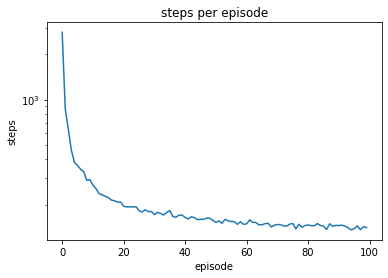

In [7]:

plt.title('steps per episode')
plt.xlabel("episode")
plt.ylabel("steps")
plt.yscale("log")
plt.plot(St_av)



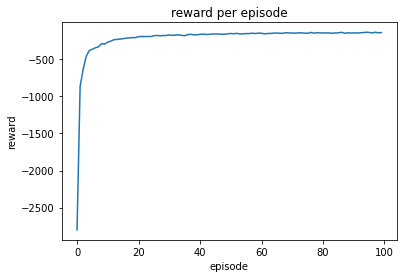

In [13]:
plt.title('reward per episode')
plt.ylabel("rewards")
plt.xlabel("episode")
plt.ylabel("reward")
plt.plot(R_av)


In [14]:
def y_x(x):
    y=0.45*np.sin(3*x)+0.55
    return y 

def animation_function(x_car,y_car,r):
    pg.init()
    scale=300
    win_x = 600
    win_y = 300
    x_car*=scale
    x_car+=405
    y_car*=-scale
    y_car+=win_y
    x_arr= np.linspace(-1.2, 0.5, 511)
    y_arr=np.empty(0,dtype=np.int8)
    y_arr=y_x(x_arr)
    y_screen=-scale*y_arr+win_y
    x_screen = np.linspace(45, 555, 511)
    win = pg.display.set_mode((win_x, win_y))
    clock = pg.time.Clock()
    win.fill((0, 0, 0))
    for i in range(len(x_arr)):
        pg.gfxdraw.pixel(win,int(x_screen[i]),int(y_screen[i]),(255,255,255))
    pg.display.update()
    for i in range(len(x_car)):
        for event in pg.event.get():
            if event.type == pg.QUIT:
                pg.quit()
        clock.tick(r)
        win.fill((0, 0, 0))
        for j in range(len(x_arr)):
            pg.gfxdraw.pixel(win,int(x_screen[j]),int(y_screen[j]),(0,255,0))
        pg.draw.rect(win,(255,255,0),(x_car[i]-10, y_car[i]-5, 20, 10))
        pg.display.update()
    pg.quit()

In [15]:
x1=np.empty(0)
y1=np.empty(0)
states=state_list[-1]
for i in range(len(states)):
    x1=np.append(x1,states[i][0])
    y1=np.append(y1,y_x(states[i][0]))

animation_function(x1,y1,50)